# Notebookの検索

## NBSearchの準備

### Solr, S3互換ストレージの用意

NBSearchはSolrおよびS3互換ストレージをバックエンドとして利用します。実際の場面で利用する場合は、Jupyterコンテナとは別にSolrサーバとS3互換ストレージを用意してください。
dockerコマンドでこれらのサービスを起動する場合の例を示します。以下のようにSolrコンテナおよびMinIOコンテナを用意し、Jupyterコンテナに接続してください。

```
# Solrの準備
git clone https://github.com/NII-cloud-operation/nbsearch /tmp/nbsearch
docker run -d --name nbsearch-solr -v /tmp/nbsearch:/tmp/nbsearch --rm solr:8 \
    bash -c "precreate-core jupyter-notebook /tmp/nbsearch/solr/jupyter-notebook/ && \
        precreate-core jupyter-cell /tmp/nbsearch/solr/jupyter-cell/ && \
        solr-foreground"

# MinIOの準備
docker run -d --rm -e MINIO_ACCESS_KEY=nbsearchak -e MINIO_SECRET_KEY=nbsearchsk \
    --name nbsearch-minio minio/minio:latest server /data --compat

# Notebookの起動
docker run -it --rm --link nbsearch-solr:solr --link nbsearch-minio:minio \
    -e NBSEARCHDB_SOLR_BASE_URL=http://solr:8983 -e NBSEARCHDB_S3_ENDPOINT_URL=http://minio:9000 \
    -e NBSEARCHDB_S3_ACCESS_KEY=nbsearchak -e NBSEARCHDB_S3_SECRET_KEY=nbsearchsk \
    -p 8888:8888 niicloudoperation/notebook
```

なお、NBSearchにSolrとS3互換ストレージの設定を与えるためには、Notebook起動時に以下の環境変数を設定してください。

- `-e NBSEARCHDB_SOLR_BASE_URL=your_solr_url` - The base URL of Solr(default: `http://localhost:8983`)
- `-e NBSEARCHDB_SOLR_BASIC_AUTH_USERNAME=your_solr_username`, `-e NBSEARCHDB_SOLR_BASIC_AUTH_PASSWORD=your_solr_password` - The username and password for Solr(if needed)
- `-e NBSEARCHDB_S3_ENDPOINT_URL=your_database_name` - The URL of S3(default: http://localhost:9000)
- `-e NBSEARCHDB_S3_ACCESS_KEY=your_s3_access_key`, `-e NBSEARCHDB_S3_SECRET_KEY=your_s3_secret_key` - The access key and secret key for S3(required)
- `-e NBSEARCHDB_S3_REGION_NAME=your_s3_region_name` - The region name of S3(if needed)
- `-e NBSEARCHDB_S3_BUCKET_NAME=your_s3_bucket_name` - The bucket on S3(required)
- `-e NBSEARCHDB_SOLR_NOTEBOOK=your_solr_notebook_core` - The core for notebooks on Solr(default: `jupyter-notebook`)
- `-e NBSEARCHDB_SOLR_CELL=your_solr_cell_core` - The core for cells on Solr(default: `jupyter-cell`)
- `-e NBSEARCHDB_BASE_DIR=your_notebook_home_dir` - Notebook directory to be searchable(default: `/home/$NB_USER`)
- `-e NBSEARCHDB_MY_SERVER_URL=your_notebook_server_url` - URL of my server, used to identify the notebooks on this server(default: `http://localhost:8888/`)
- `-e NBSEARCHDB_AUTO_UPDATE=1` - Launch lsyncd process to update the index of Solr when local files are updated automatically
- `-e NBSEARCHDB_UPDATE_INDEX_OPT` - Options for the `update-index` NBSearch command invoked by the lsyncd process


NBSearchを使用する場合は、SolrとS3互換ストレージの準備をして、`jupyter nbsearch update-index`コマンドを使用して、現在の作業ディレクトリ上にあるNotebookに基づきSolr及びS3互換ストレージを更新します。Solr, S3互換ストレージの情報に合わせて `export` の値を変更してください。

> セキュリティのため、`NBSEARCHDB_*` 環境変数の一部は、起動後のJupyter Notebookからは参照できなくなります。

In [2]:
%%bash
# 必要に応じて変更
export NBSEARCHDB_SOLR_BASE_URL=http://solr:8983
export NBSEARCHDB_S3_ENDPOINT_URL=http://minio:9000
export NBSEARCHDB_S3_ACCESS_KEY=nbsearchak
export NBSEARCHDB_S3_SECRET_KEY=nbsearchsk

jupyter nbsearch update-index --debug $CONDA_DIR/etc/jupyter/jupyter_notebook_config.py local

[UpdateIndexApp] updating indices for local, None(/opt/conda/etc/jupyter/jupyter_notebook_config.py)
[UpdateIndexApp] Using default logger
[UpdateIndexApp] updating index for notebook... {'server': 'http://localhost:8888/', 'path': '02_AWS操作用ツールのインストール.ipynb', 'mtime': datetime.datetime(2019, 9, 27, 0, 0, 16), 'atime': datetime.datetime(2019, 9, 27, 0, 0, 16)}
[UpdateIndexApp] create: notebook={'server': 'http://localhost:8888/', 'path': '02_AWS操作用ツールのインストール.ipynb', 'mtime': datetime.datetime(2019, 9, 27, 0, 0, 16), 'atime': datetime.datetime(2019, 9, 27, 0, 0, 16)}
[UpdateIndexApp] updating index for notebook... {'server': 'http://localhost:8888/', 'path': '97_Test nbextensions.ipynb', 'mtime': datetime.datetime(2019, 9, 27, 0, 0, 16), 'atime': datetime.datetime(2019, 9, 27, 0, 0, 16)}
[UpdateIndexApp] create: notebook={'server': 'http://localhost:8888/', 'path': '97_Test nbextensions.ipynb', 'mtime': datetime.datetime(2019, 9, 27, 0, 0, 16), 'atime': datetime.datetime(2019, 9, 27, 0,

今後、作業ディレクトリ上でNotebookの変更が発生した際に、MongoDB内のコレクションを更新したい場合は、以下のセルを実行し、lsyncdプロセスを起動します。

In [3]:
# 必要に応じて変更
%env NBSEARCHDB_SOLR_BASE_URL=http://solr:8983
%env NBSEARCHDB_S3_ENDPOINT_URL=http://minio:9000
%env NBSEARCHDB_S3_ACCESS_KEY=nbsearchak
%env NBSEARCHDB_S3_SECRET_KEY=nbsearchsk

!lsyncd /opt/nbsearch/update-index.lua

上記のようにlsyncdプロセスを起動するか、コンテナ起動時の環境変数に`NBSEARCHDB_AUTO_UPDATE=1`を加えることで、
ホームディレクトリ内で作成・変更したNotebookを自動的にNBSearchで検索可能になります。

### NBSearch拡張の有効化

NBSearch拡張は本イメージではデフォルトでは無効化されています。

NBextensionsタブで、 `NBSearch - Tree` と `NBSearch - Notebook` 拡張のチェックボックスを押して有効化してください。

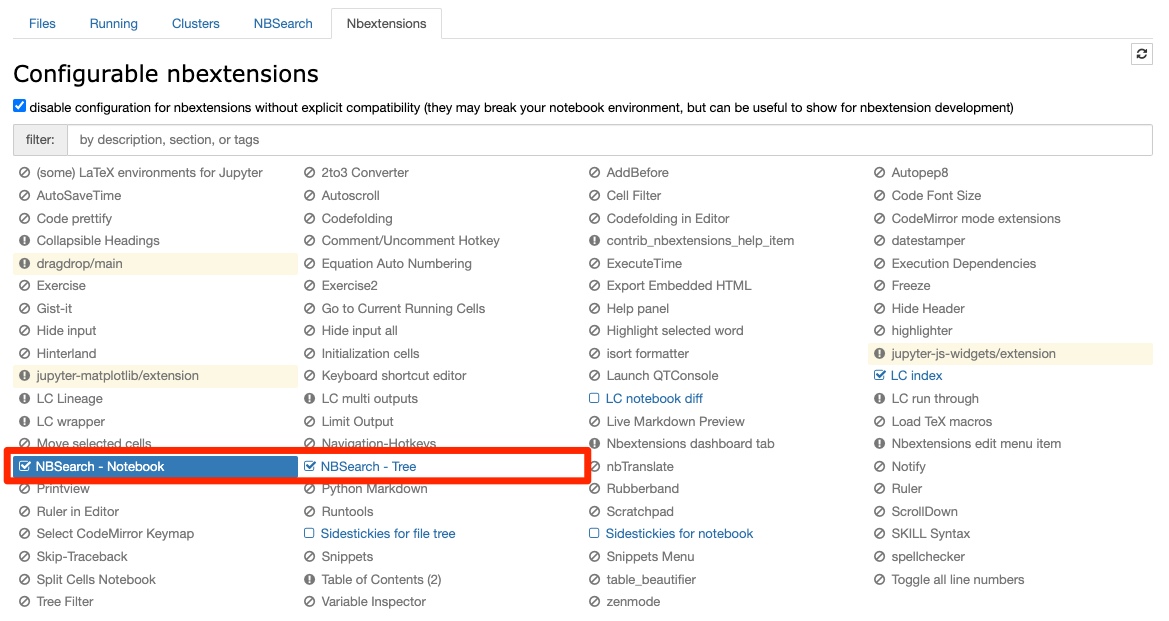

また、検索結果から `Notebookの比較` をおこないたい場合は、 `LC notebook diff` 拡張のチェックをして有効化してください。

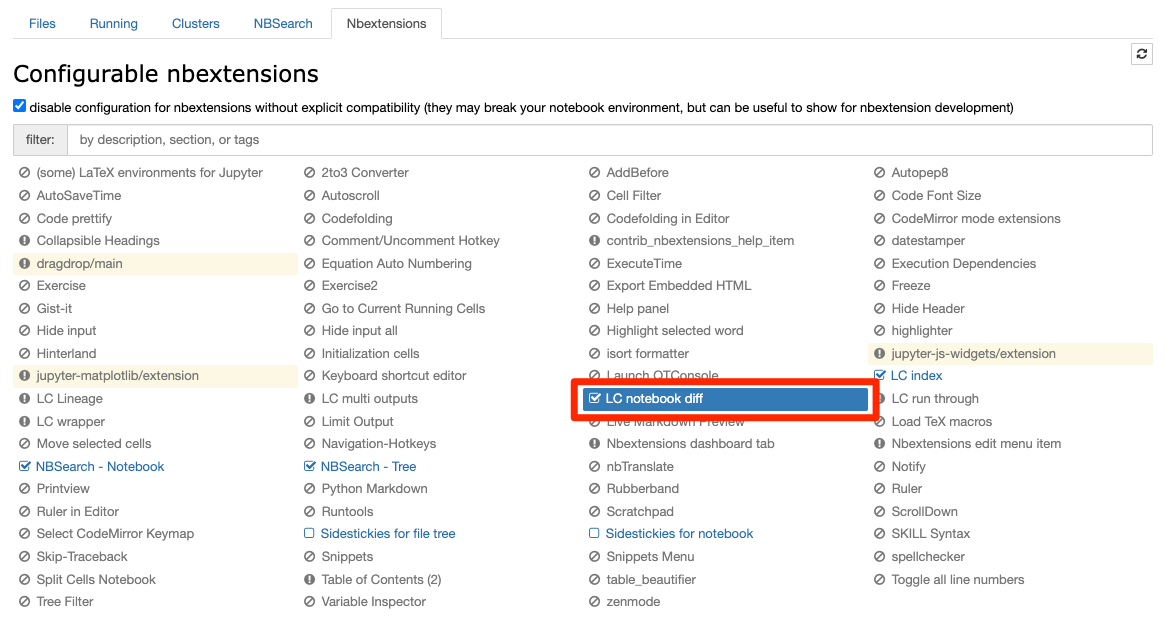

## NBSearchの使い方 - Notebookの検索

*NBSearch - Tree拡張を有効化*後、ブラウザを再読み込みするとNBSearchタブが現れます。ここから、Notebookを検索することができます。

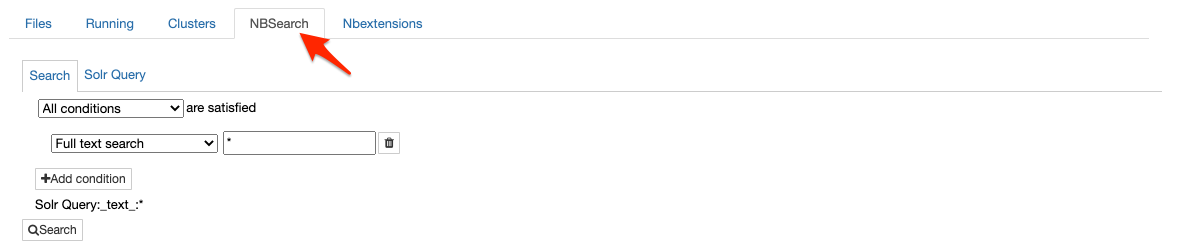

### キーワードによる検索

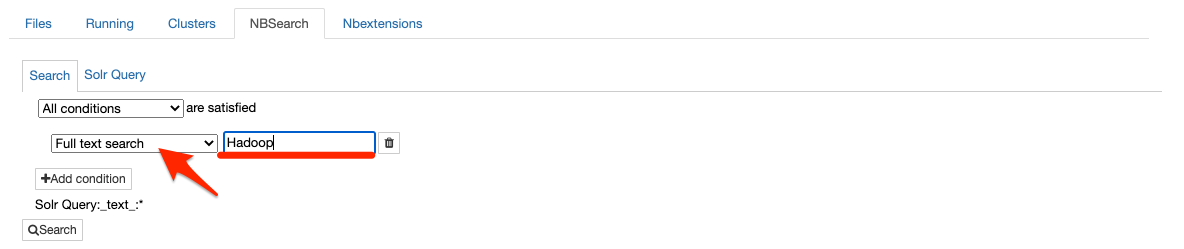

Full text search を選択し、キーワードを入力すると、Solrに保存されたNotebookに対して文字列により検索することができます。
文字列はCode Cell, Markdown Cell, Output, Pathを対象に検索されます。


### Notebookの情報に基づく検索

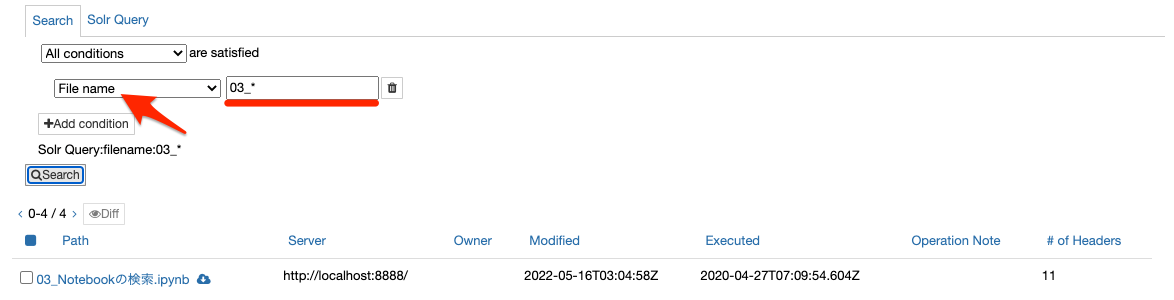

NotebookのファイルパスやサーバのURL, 更新時刻に対して検索することができます。
検索条件をドロップダウンから選択し、その後、テキストフィールドに検索条件を入力して、 検索 を実施してください。

ワイルドカードの記述方法は [Luceneクエリ構文](https://lucene.apache.org/core/2_9_4/queryparsersyntax.html) に従います。公式ドキュメント等を参考にしてください。

### Cellの情報に基づく検索

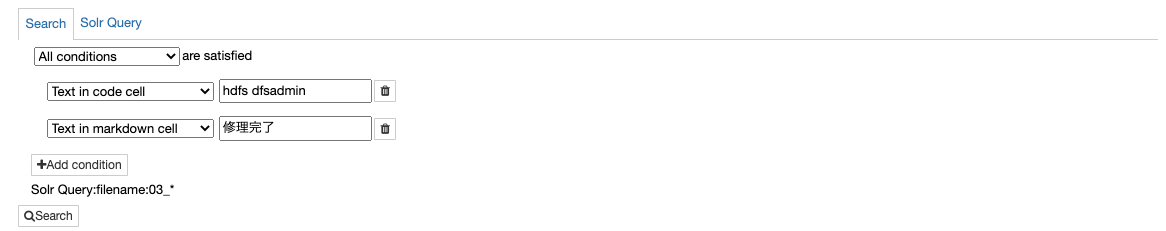

NotebookがどのようなCellを含んでいるかどうかを指定して検索することができます。
Cellに関する条件は複数設定することができます。+ボタンで複数のセル条件を追加することができます。


### 検索結果の確認

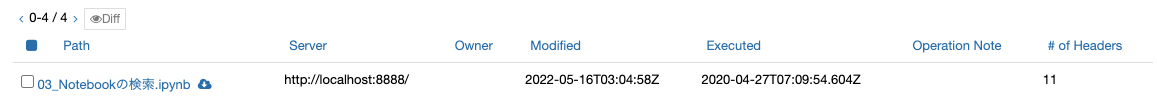

* ページの切り替え ... 検索結果が50を超える場合、 < > でページを切り替えることができます
* Diff ... 比較したいNotebookを検索結果からチェックボックスにより選択することで、 Notebook比較 を行うことができます。

#### Notebookのダウンロード

検索結果のパス名をクリックすると、Notebookを開くことができます。nbsearch-tmpというフォルダがNotebookフォルダ配下に作成され、そこに一時的にダウンロードされます。
ダウンロードボタン(雲↓)をクリックすると、現在のJupyterツリーで開いているフォルダ(Filesタブで確認できます)にNotebookをダウンロードし、開くことができます。

## NBSearchの使い方 - Cellの検索

*NBSearch - Notebook拡張を有効化*後、Notebookを開くと検索ボタンが現れます。ここから、選択しているCellに応じた検索をすることができます。

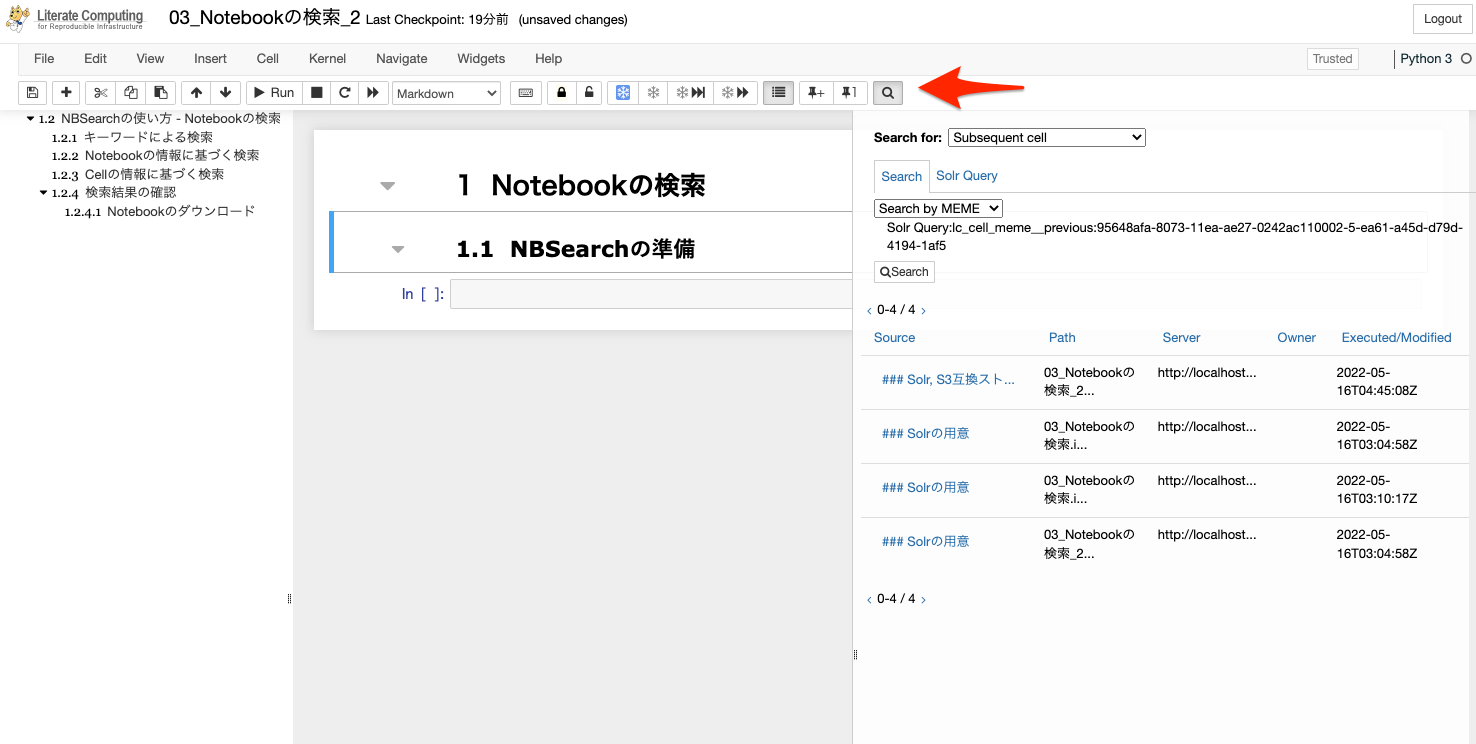

### 先行・後続するCellの検索

Search forドロップダウンからPreceding cell/Subsequent cellを選択することで、現在選択しているCellの前後に現れうるCellを検索することができます。

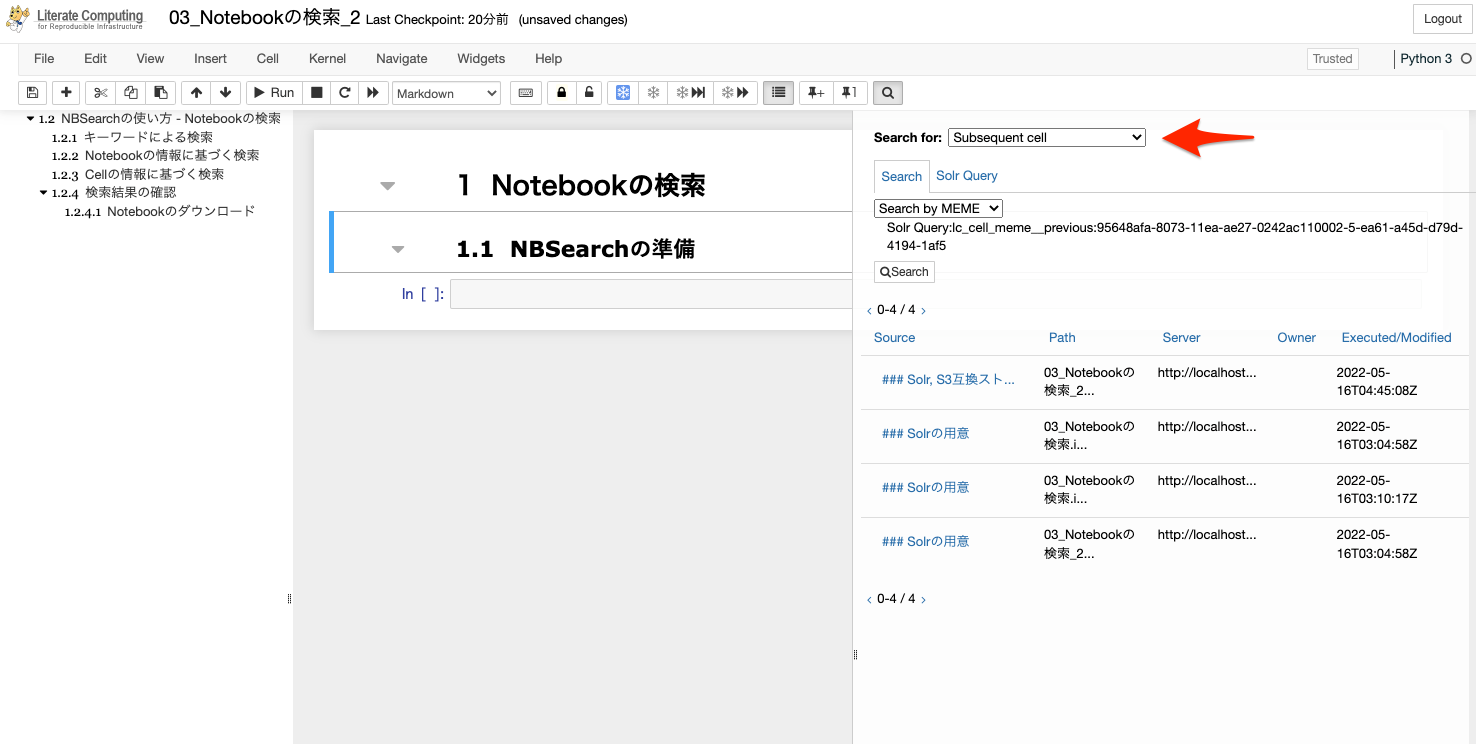

前後の検索はCellに記録されたMEMEと呼ぶ識別子に基づいて行われます。MEMEはランダムに生成される識別子で、NotebookやCellがコピーされる際に保持されます。これにより、前後に現れうるCellの検索を実現しています。

### 検索結果の反映

検索結果をクリックすると、Notebook上に + ボタンと共にセルの内容が表示されます。+ボタンを押すと、そのセルを追加することができます。

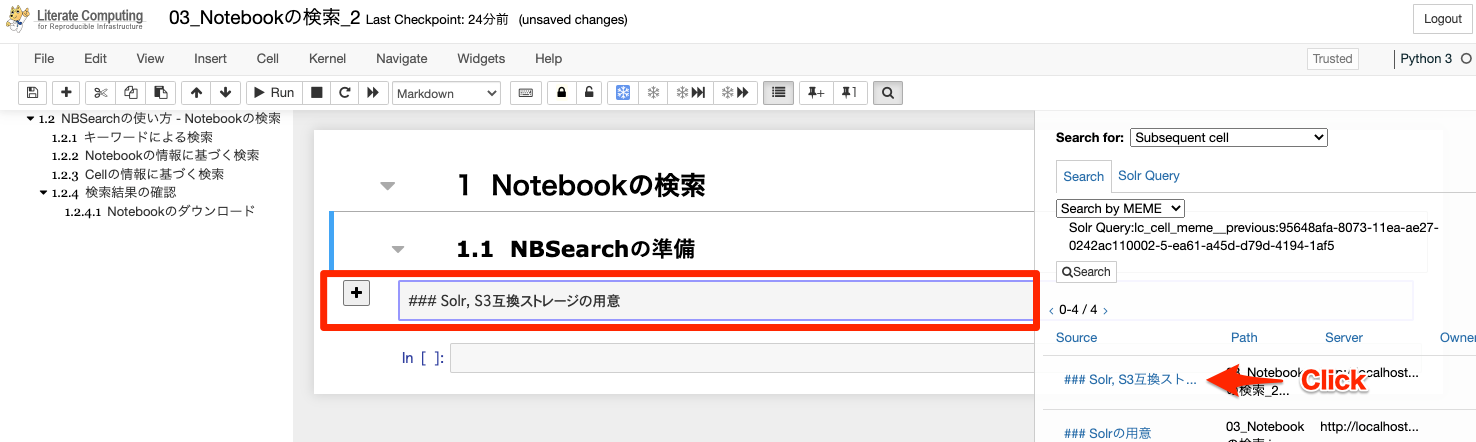